In [258]:
from casadi import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

# from math import sin, cos, exp, sqrt



In [292]:
m_l = 0.5 #mass to push off ground
k = 3000 #spring stiffness
tau_max = 0.05 #N*m stall torque
omega_max = 3000 #about 10,000rpm free speed

t = 0.2

opti = Opti()
T1 = opti.variable()
T2 = opti.variable()

x_a0 = opti.parameter()
opti.set_value(x_a0, 0)
x_l0 = opti.parameter()
opti.set_value(x_l0, 0)
v_l0 = opti.parameter()
opti.set_value(v_l0, 0)

x0 = omega_max**2
x1 = m_l*x0
x2 = 1/tau_max
x3 = T1**2
x4 = T2**2
x5 = x2*x3*x4
x6 = T1*T2*omega_max
x7 = m_l*v_l0*x6 + tau_max*x_a0
x8 = (1/2)*v_l0 - 1/2*x6
x9 = 1/T2
x10 = sqrt(fabs(-T1**4*k**2*m_l**2*x0*x4 + 4*k*m_l*tau_max**2))
x11 = (1/2)*x2
x12 = t*x10*x11*x9/m_l
x13 = exp(-k*omega_max*t*x11*x3)
x14 = x13*cos(x12)
x15 = x14*x8
x16 = 2*x15
x17 = T1**3*T2**3*x1
x18 = 2*T1*T2*tau_max*x_a0 + m_l*omega_max*v_l0*x3*x4 - 2*tau_max*x_l0 - x17
x19 = sin(x12)
x20 = x13*x19/x10
x21 = x18*x20
x22 = k*m_l*omega_max
x23 = x11*x18
x_a = -T1*x2*x21*x22 - m_l*x16*x2*x6 + omega_max*t - x1*x5 + x2*x7
x_l = T1*T2*omega_max*t + T1*T2*x2*x7 - T2*x20*x22*x23*x3 + T2*x10*x13*x19*x2*x8/k - m_l*omega_max*x15*x5 - x14*x23 - x17*x2
v_l = k*x21*x9 + x16 + x6


opti.minimize(-v_l)

opti.subject_to(opti.bounded(1e-6, T1, 0.001))
opti.subject_to(opti.bounded(1e-6, T2, 20))
# opti.subject_to(opti.bounded(0, T1**4*T2**2*k**2*m_l**2*omega_max**2 - 4*k*m_l*tau_max**2, 1))
opti.subject_to(0 > T1**4*T2**2*k**2*m_l**2*omega_max**2 - 4*k*m_l*tau_max**2)

opti.set_initial(T1, 0.0003)
opti.set_initial(T2, 5)

log = []
opti.callback(lambda i: log.append((opti.debug.value(T1), opti.debug.value(T2), opti.debug.value(v_l))))

opti.solver('ipopt')
sol = opti.solve()
sol

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        3
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        2
        inequality constraints with only upper bounds:        1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -5.0192331e+00 0.00e+00 3.53e-03  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

OptiSol(Opti {
  instance #35
  #variables: 2 (nx = 2)
  #parameters: 3 (np = 3)
  #constraints: 3 (ng = 3)
  CasADi solver allocated.
  CasADi solver was called: Solve_Succeeded
})

In [284]:
# opti.debug.value(-T1**4*k**2*m_l**2*x0*x4 + 4*k*m_l*tau_max**2)
opti.debug.value(T2)

5.199777682404053

0.0003367768457311691 5.362632423410984 5.113164058144339


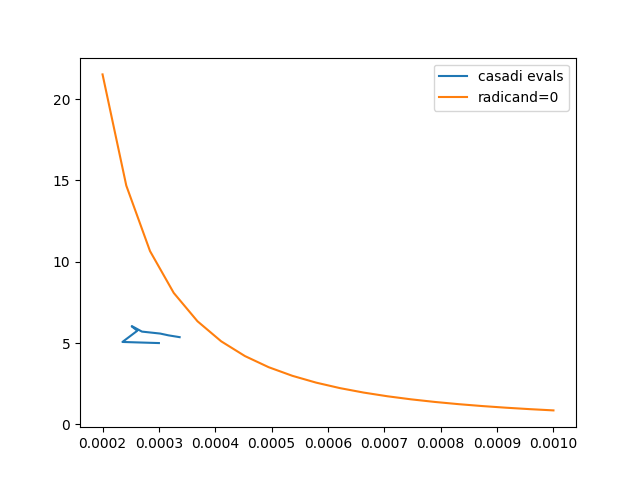

In [293]:
plt.close('a')

print(sol.value(T1), sol.value(T2), sol.value(v_l))

log = np.array(log)
T1s = log[:,0]
T2s = log[:,1]
v_ls = log[:,2]

plt.figure()
plt.plot(T1s, T2s, label='casadi evals')

testlog = []
for _T1test in np.linspace(0.0002, 0.001, 20):
    # T1**4*T2**2*k**2*m_l**2*omega_max**2 - 4*k*m_l*tau_max**2 = 0
    # 4*k*m_l*tau_max**2 = T1**4*T2**2*k**2*m_l**2*omega_max**2
    T2_test = sqrt(4*k*m_l*tau_max**2 / (_T1test**4*k**2*m_l**2*omega_max**2))
    testlog.append((_T1test, T2_test))
testlog = np.array(testlog)
plt.plot(testlog[:,0], testlog[:,1], label='radicand=0')
plt.legend()


In [274]:
sol.value(-T1**4*k**2*m_l**2*x0*x4 + 4*k*m_l*tau_max**2)

RuntimeError: Error in Opti::value [OptiNode] at .../casadi/core/optistack.cpp:173:
.../casadi/core/optistack_internal.cpp:503: Unknown: Opti decision variable 'opti31_x_1' of shape 1x1, belonging to a different instance of Opti.